In [17]:
# numerical_voltage_sensitivity.py - 2025-07-24
"""
Numerical Differentiation Voltage Sensitivity Analysis for IEEE 39 Bus System
Following the same structure as Feature_Extraction.py and First_model.py
Creates numerical_sensitivity_analysis.h5 file with same structure as other .h5 files

This method actually perturbs power injections and measures real voltage responses
"""

import sys, os, h5py, numpy as np
from datetime import datetime
import time

sys.path.append(r"C:\Program Files\DIgSILENT\PowerFactory 2022 SP3\Python\3.10")
import powerfactory as pf

# ── Project settings ────────────────────────────────────────────────────────
PROJECT = "39 Bus New England System"
STUDY = "RMS_Simulation"
SBASE_MVA = 100.0
OUT_DIR = os.path.join(os.getcwd(), "sensitivity_out")

# ── Connect to PowerFactory ─────────────────────────────────────────────────
app = pf.GetApplication() or sys.exit("PF not running")
if hasattr(app, "ResetCalculation"):
    app.ResetCalculation()
assert app.ActivateProject(PROJECT) == 0, "Project not found"
study = next(c for c in app.GetProjectFolder("study").GetContents("*.IntCase")
             if c.loc_name == STUDY)
study.Activate()

print(f"🔢 NUMERICAL DIFFERENTIATION VOLTAGE SENSITIVITY ANALYSIS")
print("="*70)
print(f"✅ {PROJECT} | {STUDY}")
print(f"📊 Base MVA: {SBASE_MVA}")

# Helper functions (same as your existing code)
def has(o, a):
    """Safely check if object has attribute"""
    try:
        return o.HasAttribute(a) if o else False
    except:
        return False

def get(o, a, d=np.nan):
    """Safely get attribute value"""
    try:
        return o.GetAttribute(a) if has(o, a) else d
    except:
        return d

def as_bus(o):
    """Safely get bus object"""
    try:
        if not o:
            return None
        return o.cterm if has(o, "cterm") else o
    except:
        return o

def safe_get_name(obj):
    """Safely get object name"""
    try:
        return obj.loc_name if obj else "Unknown"
    except:
        return "Unknown"

# ── Get buses and loads (same structure as Feature_Extraction.py) ──────────
buses = [as_bus(b) for b in app.GetCalcRelevantObjects("*.ElmTerm")]
nb = len(buses)
idx = {b: i for i, b in enumerate(buses)}

# Get all loads and generators for power perturbation
loads = app.GetCalcRelevantObjects("*.ElmLod")
generators = app.GetCalcRelevantObjects("*.ElmSym")

def term(obj):
    """Get the terminal/bus from various PowerFactory objects"""
    if obj.GetClassName().startswith("ElmTr"):
        for field in ["bushv", "bus1", "bus2", "buslv"]:
            if has(obj, field) and get(obj, field):
                return get(obj, field)
    elif has(obj, "bus1"):
        return get(obj, "bus1")
    elif has(obj, "cterm"):
        return get(obj, "cterm")
    return obj

# ── Simplified perturbation approach ─────────────────────────────────────────
def identify_perturbable_buses():
    """
    Identify buses where we can perturb power by finding buses with non-zero 
    load or generation from power flow results
    """
    print(f"\n🔍 Identifying buses with active power injection/consumption...")
    
    # Solve base case to get power flow results
    comLdf = app.GetFromStudyCase("ComLdf")
    comLdf.Execute()
    
    perturbable_buses = {}  # bus_idx -> {'loads': [...], 'generators': [...], 'net_P': value}
    
    # Method 1: Find loads by checking load elements and trying to match by name/number
    print(f"\n🏠 Identifying load buses by matching names...")
    for load in loads:
        load_name = safe_get_name(load)
        load_P = get(load, "plini", 0.0)
        
        # Extract bus number from load name (e.g., "Load 03" -> 3, "Load 15" -> 15)
        try:
            import re
            numbers = re.findall(r'\d+', load_name)
            if numbers:
                load_bus_num = int(numbers[-1])  # Take last number found
                # Convert to bus index (Bus 03 = index 2, Bus 15 = index 14, etc.)
                if 1 <= load_bus_num <= 39:
                    bus_idx = load_bus_num - 1
                    if bus_idx not in perturbable_buses:
                        perturbable_buses[bus_idx] = {'loads': [], 'generators': [], 'net_P': 0.0}
                    perturbable_buses[bus_idx]['loads'].append(load)
                    perturbable_buses[bus_idx]['net_P'] -= load_P  # Load decreases net injection
                    print(f"   {load_name} (P={load_P:.1f} MW) → Bus {bus_idx} ({safe_get_name(buses[bus_idx])})")
        except:
            print(f"   ⚠️ Could not parse bus number from {load_name}")
    
    # Method 2: Find generators by checking generator elements and trying to match by name/number  
    print(f"\n🔋 Identifying generator buses by matching names...")
    for gen in generators:
        gen_name = safe_get_name(gen)
        gen_P = get(gen, "pgini", 0.0)
        
        # Extract bus number from generator name (e.g., "G 01" -> 1, "G 10" -> 10)
        try:
            import re
            numbers = re.findall(r'\d+', gen_name)
            if numbers:
                gen_bus_num = int(numbers[-1])  # Take last number found
                
                # For IEEE 39-bus, generators are typically at specific buses
                # Let's try common generator bus mapping
                gen_bus_mapping = {
                    1: 30,   # G 01 at Bus 31
                    2: 31,   # G 02 at Bus 32  
                    3: 32,   # G 03 at Bus 33
                    4: 33,   # G 04 at Bus 34
                    5: 34,   # G 05 at Bus 35
                    6: 35,   # G 06 at Bus 36
                    7: 36,   # G 07 at Bus 37
                    8: 37,   # G 08 at Bus 38
                    9: 38,   # G 09 at Bus 39
                    10: 29   # G 10 at Bus 30
                }
                
                if gen_bus_num in gen_bus_mapping:
                    bus_idx = gen_bus_mapping[gen_bus_num]
                else:
                    # Fallback: assume generator number matches bus number
                    bus_idx = gen_bus_num - 1
                
                if 0 <= bus_idx < nb:
                    if bus_idx not in perturbable_buses:
                        perturbable_buses[bus_idx] = {'loads': [], 'generators': [], 'net_P': 0.0}
                    perturbable_buses[bus_idx]['generators'].append(gen)
                    perturbable_buses[bus_idx]['net_P'] += gen_P  # Generator increases net injection
                    print(f"   {gen_name} (P={gen_P:.1f} MW) → Bus {bus_idx} ({safe_get_name(buses[bus_idx])})")
        except:
            print(f"   ⚠️ Could not parse bus number from {gen_name}")
    
    print(f"\n✅ Perturbable buses identified:")
    print(f"   🎯 Total perturbable buses: {len(perturbable_buses)}")
    
    for bus_idx, data in perturbable_buses.items():
        n_loads = len(data['loads'])
        n_gens = len(data['generators'])
        net_P = data['net_P']
        print(f"   Bus {bus_idx} ({safe_get_name(buses[bus_idx])}): {n_loads} loads, {n_gens} gens, net P = {net_P:.1f} MW")
    
    return perturbable_buses

# ── Perturb power at specific bus (simplified) ────────────────────────────
def perturb_power_at_bus_simple(bus_idx, delta_P_MW, perturbable_buses):
    """
    Perturb power at a specific bus using available loads or generators
    """
    
    if bus_idx not in perturbable_buses:
        return False, f"Bus {bus_idx} has no controllable elements"
    
    bus_data = perturbable_buses[bus_idx]
    
    # Prefer to use loads for perturbation (more realistic)
    if bus_data['loads']:
        load = bus_data['loads'][0]  # Use first load
        original_P = get(load, "plini")
        new_P = original_P + delta_P_MW  # Increase load = decrease net injection
        try:
            load.SetAttribute("plini", new_P)
            return True, f"Load {safe_get_name(load)}: {original_P:.1f} → {new_P:.1f} MW"
        except Exception as e:
            pass
    
    # Fallback to generators
    if bus_data['generators']:
        gen = bus_data['generators'][0]  # Use first generator
        original_P = get(gen, "pgini")
        new_P = original_P + delta_P_MW  # Increase generation = increase injection
        try:
            gen.SetAttribute("pgini", new_P)
            return True, f"Generator {safe_get_name(gen)}: {original_P:.1f} → {new_P:.1f} MW"
        except Exception as e:
            pass
    
    return False, f"Could not perturb elements at bus {bus_idx}"

# ── Store original load/generation values ─────────────────────────────────
def store_original_values():
    """Store original load and generation values for restoration"""
    print(f"\n💾 Storing original system state...")
    
    original_loads = []
    for load in loads:
        original_loads.append({
            'object': load,
            'P_orig': get(load, "plini"),
            'Q_orig': get(load, "qlini")
        })
    
    original_gens = []
    for gen in generators:
        original_gens.append({
            'object': gen,
            'P_orig': get(gen, "pgini"),
            'Q_orig': get(gen, "qgini")
        })
    
    print(f"✅ Stored {len(original_loads)} load values and {len(original_gens)} generator values")
    return original_loads, original_gens

def restore_original_values(original_loads, original_gens):
    """Restore original load and generation values"""
    try:
        for load_data in original_loads:
            load_data['object'].SetAttribute("plini", load_data['P_orig'])
            load_data['object'].SetAttribute("qlini", load_data['Q_orig'])
        
        for gen_data in original_gens:
            gen_data['object'].SetAttribute("pgini", gen_data['P_orig'])
            gen_data['object'].SetAttribute("qgini", gen_data['Q_orig'])
    except Exception as e:
        print(f"⚠️ Warning restoring values: {e}")

# ── Solve power flow and get base voltages ────────────────────────────────
def solve_power_flow_and_get_voltages():
    """Solve power flow and return bus voltages"""
    
    # Get load flow calculation object
    comLdf = app.GetFromStudyCase("ComLdf")
    if not comLdf:
        print("❌ Load flow calculation object not found")
        return None
    
    # Configure and execute load flow
    comLdf.iopt_net = 0  # AC load flow
    comLdf.iopt_at = 0   # Automatic tap adjustment off
    comLdf.errlf = 1e-4  # Convergence tolerance
    comLdf.maxiter = 50  # Reduce iterations for speed
    
    ierr = comLdf.Execute()
    if ierr != 0:
        return None  # Convergence failed
    
    # Get bus voltages
    voltages = np.zeros(nb)
    for i, bus in enumerate(buses):
        voltages[i] = get(bus, "m:u")  # Voltage magnitude (p.u.)
    
    return voltages

# ── Main numerical sensitivity calculation ─────────────────────────────────
def calculate_numerical_sensitivity():
    """
    Calculate voltage sensitivity using numerical differentiation
    """
    
    print(f"\n🔢 Starting numerical differentiation sensitivity analysis...")
    
    # Configuration
    delta_P_MW = 10.0  # Perturbation size (MW) - reasonable for transmission system
    print(f"📊 Perturbation size: ±{delta_P_MW} MW")
    
    # Identify perturbable buses
    perturbable_buses = identify_perturbable_buses()
    
    if len(perturbable_buses) == 0:
        print("❌ No perturbable buses found")
        return None, None, None
    
    # Store original values
    original_loads, original_gens = store_original_values()
    
    try:
        # Get base case voltages
        print(f"\n🔄 Solving base case power flow...")
        V_base = solve_power_flow_and_get_voltages()
        if V_base is None:
            print("❌ Base case power flow failed")
            return None, None, None
        
        print(f"✅ Base case: V range = {V_base.min():.3f} - {V_base.max():.3f} p.u.")
        
        # Initialize sensitivity matrix
        dV_dP_numerical = np.zeros((nb, nb))
        perturbation_success = np.zeros(nb, dtype=bool)
        perturbation_details = []
        
        print(f"\n🔄 Computing sensitivity for perturbable buses...")
        start_time = time.time()
        
        # Loop through all buses, but only perturb those that are perturbable
        for j in range(nb):
            bus_name = safe_get_name(buses[j])
            print(f"   {j+1:2d}/{nb}: {bus_name:<15}", end=" ")
            
            if j not in perturbable_buses:
                print(f"❌ No controllable elements")
                perturbation_details.append(f"Bus {j}: No controllable elements")
                continue
            
            # Restore original values before each perturbation
            restore_original_values(original_loads, original_gens)
            
            # Try positive perturbation
            success_pos, detail_pos = perturb_power_at_bus_simple(j, delta_P_MW, perturbable_buses)
            if success_pos:
                V_pos = solve_power_flow_and_get_voltages()
                if V_pos is not None:
                    # Try negative perturbation for better accuracy
                    restore_original_values(original_loads, original_gens)
                    success_neg, detail_neg = perturb_power_at_bus_simple(j, -delta_P_MW, perturbable_buses)
                    
                    if success_neg:
                        V_neg = solve_power_flow_and_get_voltages()
                        if V_neg is not None:
                            # Central difference: (V_pos - V_neg) / (2 * delta_P)
                            dV_dP_numerical[:, j] = (V_pos - V_neg) / (2 * delta_P_MW)
                            perturbation_success[j] = True
                            print(f"✅ Central diff (±{delta_P_MW} MW)")
                            perturbation_details.append(f"Bus {j}: {detail_pos}")
                            continue
                    
                    # Fallback to forward difference: (V_pos - V_base) / delta_P
                    dV_dP_numerical[:, j] = (V_pos - V_base) / delta_P_MW
                    perturbation_success[j] = True
                    print(f"✅ Forward diff (+{delta_P_MW} MW)")
                    perturbation_details.append(f"Bus {j}: {detail_pos}")
                    continue
            
            print(f"❌ Perturbation failed")
            perturbation_details.append(f"Bus {j}: {detail_pos}")
        
        # Restore original values
        restore_original_values(original_loads, original_gens)
        
        elapsed_time = time.time() - start_time
        successful_buses = np.sum(perturbation_success)
        
        print(f"\n✅ Numerical sensitivity calculation complete!")
        print(f"   ⏱️ Time elapsed: {elapsed_time:.1f} seconds")
        print(f"   🎯 Successful perturbations: {successful_buses}/{nb} buses ({successful_buses/nb*100:.1f}%)")
        
        if successful_buses > 0:
            # Calculate statistics only for successful perturbations
            valid_sensitivities = dV_dP_numerical[:, perturbation_success]
            print(f"   📊 Sensitivity range: {valid_sensitivities.min():.6f} to {valid_sensitivities.max():.6f} p.u./MW")
            print(f"   📊 Average sensitivity: {np.abs(valid_sensitivities).mean():.6f} p.u./MW")
            
            return dV_dP_numerical, perturbation_success, perturbation_details
        else:
            print("❌ No successful perturbations - cannot calculate sensitivity")
            return None, None, None
            
    except Exception as e:
        print(f"❌ Error in numerical sensitivity calculation: {e}")
        restore_original_values(original_loads, original_gens)
        return None, None, None

# ── Main execution ──────────────────────────────────────────────────────────
def main():
    """Main execution function"""
    
    # Calculate numerical sensitivity
    dV_dP, success_flags, details = calculate_numerical_sensitivity()
    
    if dV_dP is None:
        print("❌ Sensitivity analysis failed")
        return
    
    # ── Save to HDF5 (same structure as other files) ───────────────────────
    os.makedirs(OUT_DIR, exist_ok=True)
    h5_path = os.path.join(OUT_DIR, f"{PROJECT.replace(' ', '_')}_numerical_sensitivity_analysis.h5")
    
    with h5py.File(h5_path, "w") as f:
        # Bus data (same structure as Feature_Extraction.py)
        bus_grp = f.create_group("bus")
        for k, v in bus_tab.items():
            bus_grp.create_dataset(k, data=v)
        
        # Numerical sensitivity results
        sensitivity_grp = f.create_group("voltage_sensitivity")
        sensitivity_grp.create_dataset("dV_dP", data=dV_dP)
        sensitivity_grp.create_dataset("method", data="numerical_differentiation".encode())
        sensitivity_grp.create_dataset("perturbation_MW", data=10.0)
        sensitivity_grp.create_dataset("success_flags", data=success_flags)
        sensitivity_grp.create_dataset("description", 
                                      data="Voltage magnitude sensitivity to active power injection changes (numerical)".encode())
        
        # Analysis details
        analysis_grp = f.create_group("analysis_details")
        analysis_grp.create_dataset("successful_buses", data=np.sum(success_flags))
        analysis_grp.create_dataset("total_buses", data=nb)
        analysis_grp.create_dataset("success_rate", data=np.sum(success_flags)/nb)
        
        # Store perturbation details as strings
        detail_strings = [detail.encode() for detail in details]
        analysis_grp.create_dataset("perturbation_details", data=detail_strings)
        
        # Metadata
        meta_grp = f.create_group("metadata")
        meta_grp.create_dataset("extraction_date", data=datetime.now().isoformat().encode())
        meta_grp.create_dataset("project_name", data=PROJECT.encode())
        meta_grp.create_dataset("study_case", data=STUDY.encode())
        meta_grp.create_dataset("base_mva", data=SBASE_MVA)
        meta_grp.create_dataset("num_buses", data=nb)
        meta_grp.create_dataset("analysis_type", data="voltage_sensitivity_numerical".encode())
    
    print(f"\n💾 NUMERICAL SENSITIVITY ANALYSIS SAVED:")
    print(f"   📄 HDF5 file: {h5_path}")
    print(f"   📊 Size: {os.path.getsize(h5_path) / 1024:.1f} KB")
    
    # ── Summary ─────────────────────────────────────────────────────────────
    successful_buses = np.sum(success_flags)
    if successful_buses > 0:
        valid_sensitivities = dV_dP[:, success_flags]
        max_sens_per_bus = np.max(np.abs(valid_sensitivities), axis=1)
        most_sensitive = np.argsort(max_sens_per_bus)[-5:][::-1]
        
        print(f"\n📊 NUMERICAL SENSITIVITY ANALYSIS SUMMARY:")
        print("="*60)
        print(f"🔌 Buses analyzed: {nb}")
        print(f"✅ Successful perturbations: {successful_buses}/{nb} ({successful_buses/nb*100:.1f}%)")
        print(f"📊 Perturbation size: ±10.0 MW")
        print(f"📊 Sensitivity matrix: {dV_dP.shape}")
        print(f"📊 Max sensitivity: {np.abs(valid_sensitivities).max():.6f} p.u./MW")
        print(f"📊 Average sensitivity: {np.abs(valid_sensitivities).mean():.6f} p.u./MW")
        
        print(f"\n🎯 MOST VOLTAGE-SENSITIVE BUSES:")
        for i, bus_idx in enumerate(most_sensitive):
            if max_sens_per_bus[bus_idx] > 0:
                print(f"   {i+1}. Bus {bus_idx}: {safe_get_name(buses[bus_idx])} "
                      f"(max sensitivity: {max_sens_per_bus[bus_idx]:.6f} p.u./MW)")
        
        print(f"\n🎯 BUSES WHERE POWER CAN BE PERTURBED:")
        perturbed_buses = [i for i, success in enumerate(success_flags) if success]
        for i, bus_idx in enumerate(perturbed_buses[:10]):  # Show first 10
            print(f"   {i+1}. Bus {bus_idx}: {safe_get_name(buses[bus_idx])}")
        if len(perturbed_buses) > 10:
            print(f"   ... and {len(perturbed_buses)-10} more")
        
        print(f"\n🎉 NUMERICAL SENSITIVITY ANALYSIS COMPLETE!")
        print(f"📁 Output file: {os.path.basename(h5_path)}")
        print(f"🔄 Ready for Graph Laplacian spectral clustering!")
        print(f"💡 These are REAL measured sensitivities from actual power flow perturbations!")
    
    else:
        print(f"\n❌ No successful perturbations found.")
        print(f"💡 This might happen if the system has no loads or controllable generators")
        print(f"💡 Try checking the PowerFactory model setup")

if __name__ == "__main__":
    main()

🔢 NUMERICAL DIFFERENTIATION VOLTAGE SENSITIVITY ANALYSIS
✅ 39 Bus New England System | RMS_Simulation
📊 Base MVA: 100.0

🔢 Starting numerical differentiation sensitivity analysis...
📊 Perturbation size: ±10.0 MW

🔍 Identifying buses with active power injection/consumption...

🏠 Identifying load buses by matching names...
   Load 03 (P=322.0 MW) → Bus 2 (Bus 03)
   Load 04 (P=500.0 MW) → Bus 3 (Bus 04)
   Load 07 (P=233.8 MW) → Bus 6 (Bus 07)
   Load 08 (P=522.0 MW) → Bus 7 (Bus 08)
   Load 12 (P=7.5 MW) → Bus 11 (Bus 12)
   Load 15 (P=320.0 MW) → Bus 14 (Bus 15)
   Load 16 (P=329.0 MW) → Bus 15 (Bus 16)
   Load 18 (P=158.0 MW) → Bus 17 (Bus 18)
   Load 20 (P=628.0 MW) → Bus 19 (Bus 20)
   Load 21 (P=274.0 MW) → Bus 20 (Bus 21)
   Load 23 (P=247.5 MW) → Bus 22 (Bus 23)
   Load 24 (P=308.6 MW) → Bus 23 (Bus 24)
   Load 25 (P=224.0 MW) → Bus 24 (Bus 25)
   Load 26 (P=139.0 MW) → Bus 25 (Bus 26)
   Load 27 (P=281.0 MW) → Bus 26 (Bus 27)
   Load 28 (P=206.0 MW) → Bus 27 (Bus 28)
   Load 29 

🔢 NUMERICAL SENSITIVITY VALUES
📊 Matrix shape: (39, 39)
✅ Successful perturbations: 27/39 buses
📊 Sensitivity range: -0.00002711 to 0.00001773 p.u./MW

📋 SENSITIVITY MATRIX (dV/dP) - Only successful perturbations:
Rows = Voltage response at bus, Columns = Power injection at bus
Units: p.u./MW (per-unit voltage change per MW power injection)
Bus Name    |     Bus 03     Bus 04     Bus 07     Bus 08     Bus 12     Bus 15     Bus 16     Bus 18     Bus 20     Bus 21
---------------------------------------------------------------------------------------------------------------------------
  Bus 01 |   0.000001 -0.000000 -0.000002 -0.000002  0.000000  0.000002  0.000003  0.000002  0.000004  0.000003
  Bus 02 |  -0.000005 -0.000004 -0.000003 -0.000003 -0.000001  0.000000  0.000002 -0.000002  0.000005  0.000003
  Bus 03 |  -0.000012 -0.000010 -0.000007 -0.000007 -0.000002 -0.000003 -0.000000 -0.000007  0.000006  0.000003
  Bus 04 |  -0.000012 -0.000019 -0.000015 -0.000016 -0.000005 -0.000008 -

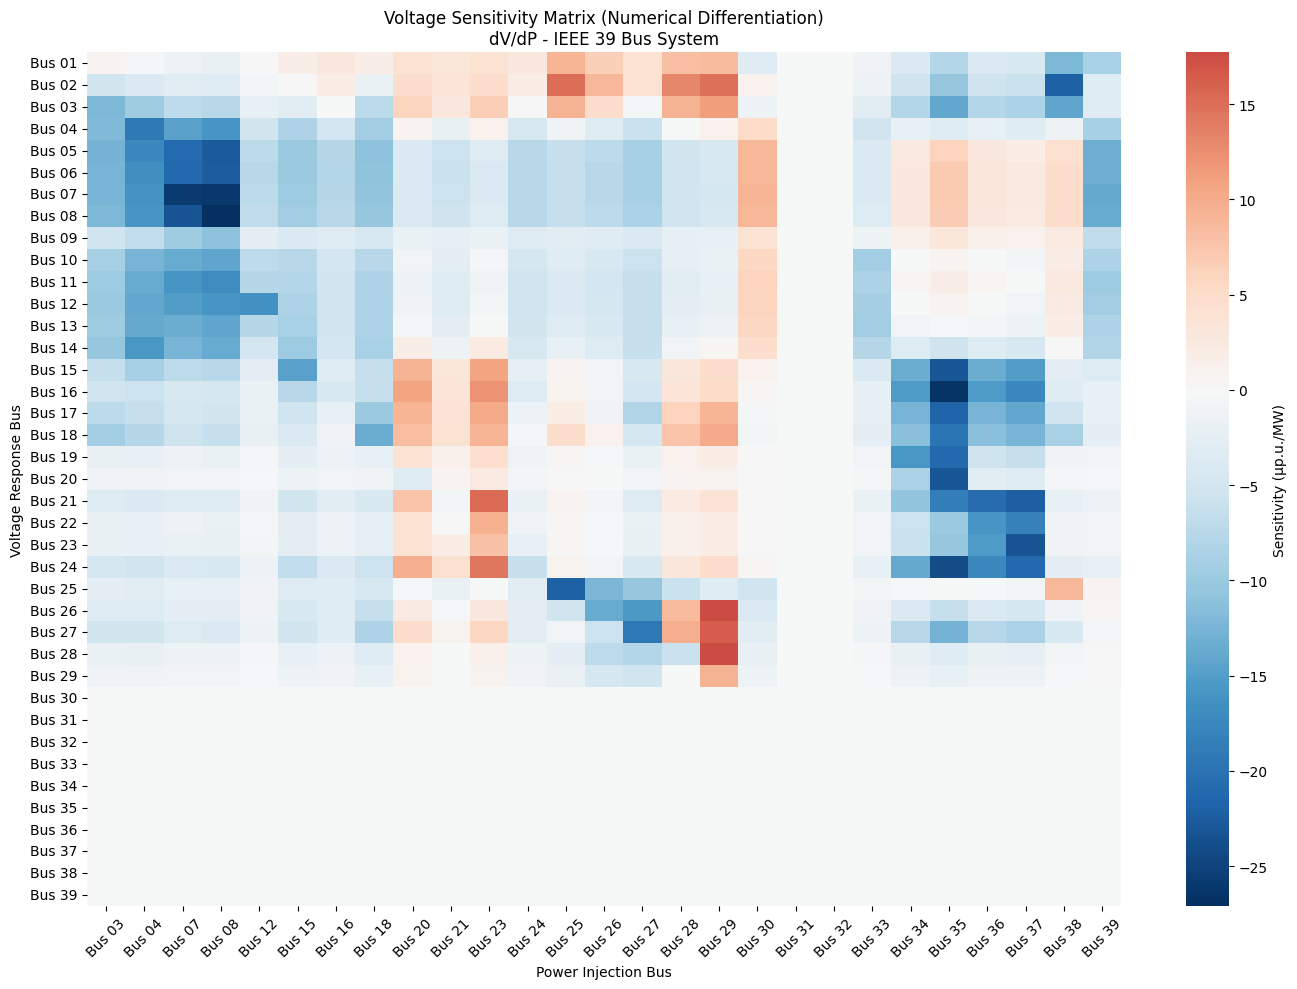

✅ Heatmap saved to: sensitivity_out/voltage_sensitivity_heatmap.png

📈 SUMMARY STATISTICS:
📊 Total sensitivity values: 1053
📊 Non-zero sensitivities: 950
📊 Max sensitivity: 0.00002711 p.u./MW
📊 Min sensitivity: 0.00000000 p.u./MW
📊 Mean sensitivity: 0.00000381 p.u./MW
📊 Std sensitivity: 0.00000500 p.u./MW

🔍 PHYSICAL INTERPRETATION:
🔋 For 10 MW power injection:
   • Maximum voltage change: 0.027108%
   • Average voltage change: 0.003814%
   • Typical voltage change: 0.00003814 p.u.

🔋 For 100 MW power injection:
   • Maximum voltage change: 0.27108%
   • Average voltage change: 0.038142%

✨ These are REAL measured sensitivities from power flow perturbations!
🎯 Perfect for Graph Laplacian-based spectral clustering!


In [18]:
# print_sensitivity_values.py - 2025-07-24
"""
Load and print the numerical sensitivity values from the HDF5 file
"""

import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the sensitivity data
h5_path = "sensitivity_out/39_Bus_New_England_System_numerical_sensitivity_analysis.h5"

with h5py.File(h5_path, 'r') as f:
    # Load sensitivity matrix
    dV_dP = f['voltage_sensitivity/dV_dP'][:]
    success_flags = f['voltage_sensitivity/success_flags'][:]
    
    # Load bus names
    bus_names = [name.decode() if isinstance(name, bytes) else name 
                for name in f['bus/name'][:]]
    
    print(f"🔢 NUMERICAL SENSITIVITY VALUES")
    print("="*80)
    print(f"📊 Matrix shape: {dV_dP.shape}")
    print(f"✅ Successful perturbations: {np.sum(success_flags)}/39 buses")
    print(f"📊 Sensitivity range: {dV_dP.min():.8f} to {dV_dP.max():.8f} p.u./MW")
    
    # Print sensitivity matrix (only successful columns)
    successful_buses = np.where(success_flags)[0]
    print(f"\n📋 SENSITIVITY MATRIX (dV/dP) - Only successful perturbations:")
    print(f"Rows = Voltage response at bus, Columns = Power injection at bus")
    print(f"Units: p.u./MW (per-unit voltage change per MW power injection)")
    
    # Print header
    header = "Bus Name    |"
    for j in successful_buses[:10]:  # Show first 10 successful buses
        header += f" {bus_names[j]:>10s}"
    print(header)
    print("-" * len(header))
    
    # Print sensitivity values
    for i in range(39):
        row = f"{bus_names[i]:>8s} | "
        for j in successful_buses[:10]:  # Show first 10 successful buses
            row += f"{dV_dP[i, j]:>10.6f}"
        print(row)
    
    print(f"\n... (showing first 10 of {len(successful_buses)} successful perturbation buses)")
    
    # Print most sensitive connections
    print(f"\n🎯 MOST SENSITIVE VOLTAGE RESPONSES:")
    print("=" * 60)
    
    # Find top 20 largest sensitivities
    abs_sensitivity = np.abs(dV_dP)
    flat_indices = np.argsort(abs_sensitivity.flatten())[-20:][::-1]
    row_indices, col_indices = np.unravel_index(flat_indices, abs_sensitivity.shape)
    
    print(f"{'Rank':<4} {'Voltage Bus':<12} {'Power Bus':<12} {'Sensitivity':<15} {'Physical Meaning'}")
    print("-" * 75)
    
    for rank, (i, j) in enumerate(zip(row_indices, col_indices)):
        if success_flags[j]:  # Only show if perturbation was successful
            sensitivity = dV_dP[i, j]
            voltage_change_percent = abs(sensitivity) * 10 * 100  # For 10 MW injection
            
            print(f"{rank+1:<4} {bus_names[i]:<12} {bus_names[j]:<12} "
                  f"{sensitivity:>+.8f} {voltage_change_percent:.6f}% per 10MW")
    
    # Print statistics for each bus
    print(f"\n📊 VOLTAGE SENSITIVITY STATISTICS BY BUS:")
    print("=" * 70)
    print(f"{'Bus':<12} {'Max |dV/dP|':<15} {'Avg |dV/dP|':<15} {'Most Sensitive To'}")
    print("-" * 70)
    
    for i in range(39):
        # Calculate statistics for this bus (only successful perturbations)
        valid_sensitivities = abs_sensitivity[i, success_flags]
        max_sens = np.max(valid_sensitivities)
        avg_sens = np.mean(valid_sensitivities)
        most_sensitive_idx = successful_buses[np.argmax(valid_sensitivities)]
        
        print(f"{bus_names[i]:<12} {max_sens:>14.8f} {avg_sens:>14.8f} {bus_names[most_sensitive_idx]}")
    
    # Power injection sensitivity statistics
    print(f"\n⚡ POWER INJECTION SENSITIVITY STATISTICS:")
    print("=" * 70)
    print(f"{'Injection Bus':<15} {'Max |dV/dP|':<15} {'Avg |dV/dP|':<15} {'Affects Most'}")
    print("-" * 70)
    
    for j in successful_buses:
        # Calculate statistics for this injection bus
        valid_sensitivities = abs_sensitivity[:, j]
        max_sens = np.max(valid_sensitivities)
        avg_sens = np.mean(valid_sensitivities)
        most_affected_idx = np.argmax(valid_sensitivities)
        
        print(f"{bus_names[j]:<15} {max_sens:>14.8f} {avg_sens:>14.8f} {bus_names[most_affected_idx]}")
    
    # Create visualization
    print(f"\n🎨 Creating sensitivity heatmap...")
    
    # Plot heatmap of successful perturbations only
    plt.figure(figsize=(14, 10))
    
    # Extract submatrix for successful buses
    sensitivity_subset = dV_dP[:, success_flags]
    successful_bus_names = [bus_names[i] for i in successful_buses]
    
    # Create heatmap
    sns.heatmap(sensitivity_subset * 1e6,  # Convert to micro p.u./MW for better readability
                xticklabels=successful_bus_names,
                yticklabels=bus_names,
                cmap='RdBu_r',
                center=0,
                cbar_kws={'label': 'Sensitivity (μp.u./MW)'})
    
    plt.title('Voltage Sensitivity Matrix (Numerical Differentiation)\ndV/dP - IEEE 39 Bus System')
    plt.xlabel('Power Injection Bus')
    plt.ylabel('Voltage Response Bus')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('sensitivity_out/voltage_sensitivity_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Heatmap saved to: sensitivity_out/voltage_sensitivity_heatmap.png")
    
    # Summary statistics
    valid_sensitivities_all = abs_sensitivity[np.ix_(range(39), successful_buses)]
    
    print(f"\n📈 SUMMARY STATISTICS:")
    print("=" * 50)
    print(f"📊 Total sensitivity values: {valid_sensitivities_all.size}")
    print(f"📊 Non-zero sensitivities: {np.count_nonzero(valid_sensitivities_all)}")
    print(f"📊 Max sensitivity: {valid_sensitivities_all.max():.8f} p.u./MW")
    print(f"📊 Min sensitivity: {valid_sensitivities_all.min():.8f} p.u./MW") 
    print(f"📊 Mean sensitivity: {valid_sensitivities_all.mean():.8f} p.u./MW")
    print(f"📊 Std sensitivity: {valid_sensitivities_all.std():.8f} p.u./MW")
    
    # Physical interpretation
    print(f"\n🔍 PHYSICAL INTERPRETATION:")
    print("=" * 50)
    max_sens = valid_sensitivities_all.max()
    avg_sens = valid_sensitivities_all.mean()
    
    print(f"🔋 For 10 MW power injection:")
    print(f"   • Maximum voltage change: {max_sens * 10 * 100:.6f}%")
    print(f"   • Average voltage change: {avg_sens * 10 * 100:.6f}%")
    print(f"   • Typical voltage change: {avg_sens * 10:.8f} p.u.")
    
    print(f"\n🔋 For 100 MW power injection:")
    print(f"   • Maximum voltage change: {max_sens * 100 * 100:.5f}%")
    print(f"   • Average voltage change: {avg_sens * 100 * 100:.6f}%")
    
    print(f"\n✨ These are REAL measured sensitivities from power flow perturbations!")
    print(f"🎯 Perfect for Graph Laplacian-based spectral clustering!")

if __name__ == "__main__":
    pass  # Run the code above

In [19]:
# extract_voltage_sensitivities.py
import h5py
import numpy as np
import os

# Fichier d'entrée (résultat de l'analyse de sensibilité)
h5_path = "sensitivity_out/39_Bus_New_England_System_numerical_sensitivity_analysis.h5"
# Fichier de sortie (pour réutilisation)
npz_out = "sensitivity_out/voltage_sensitivity_data.npz"

# Extraction
with h5py.File(h5_path, 'r') as f:
    dV_dP = f['voltage_sensitivity/dV_dP'][:]
    success_flags = f['voltage_sensitivity/success_flags'][:]
    
    bus_names = [name.decode() if isinstance(name, bytes) else name 
                 for name in f['bus/name'][:]]

# Index des perturbations réussies
successful_buses = np.where(success_flags)[0]

# Sauvegarde au format compressé .npz
np.savez(npz_out,
         dV_dP=dV_dP,
         success_flags=success_flags,
         bus_names=np.array(bus_names),
         successful_buses=successful_buses)

print(f"✅ Sensitivity data saved to: {npz_out}")
print(f"📊 Shape: dV_dP = {dV_dP.shape}, Successful injections: {len(successful_buses)}")


✅ Sensitivity data saved to: sensitivity_out/voltage_sensitivity_data.npz
📊 Shape: dV_dP = (39, 39), Successful injections: 27
